# Homework 4



## Question 1: Propensity score matching


In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

Dataset description

 - treat: 1 if the subject participated in the job training program, 0 otherwise
 - age: the subject's age
 - educ: years of education
 - race: categorical variable with three possible values: Black, Hispanic, or White
 - married: 1 if the subject was married at the time of the training program, 0 otherwise
 - nodegree: 1 if the subject has earned no school degree, 0 otherwise
 - re74: real earnings in 1974 (pre-treatment)
 - re75: real earnings in 1975 (pre-treatment)
 - re78: real earnings in 1978 (outcome)
 

 
 
 
## Solution

First we will define several methods for plotting the data that will be useful later. After this we read the data and do naive analysis.


In [29]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from sklearn import linear_model
sns.set(font_scale=1)
sns.axes_style("darkgrid")
flatui = ["#e74c3c", "#3498db", "#2ecc71", "#34495e", "#9b59b6", "#95a5a6"]
sns.set_palette(flatui)

### Plotting functions

It will be useful for later to have defined some plotting functions to show the distributions for different features in our dataset. 

In [30]:
def plot_bar_box(x, y, data, xticklabels, ylabel, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax1 = sns.barplot(x=x, y=y, data=data, ax=ax[0])
    ax2 = sns.boxplot(x=x, y=y, data=data, ax=ax[1])
    ax1.set_xticklabels(xticklabels)
    ax2.set_xticklabels(xticklabels)
    ax1.set_ylabel(ylabel)
    ax2.set_ylabel(ylabel)
    ax1.set_title(title)
    ax2.set_title(title)
    plt.show()
                
def plot_distrib(data, column):
        fig, ax = plt.subplots(figsize=(10, 6))
        df_treat = data.query('treat == 1')[column]
        df_control = data.query('treat == 0')[column]
        sns.distplot(df_treat, color=flatui[0])
        sns.distplot(df_control, color=flatui[1])
        

def plot_histogram(data, x, y, hue, xticklabels, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax1 = sns.barplot(x=x, y=y, hue=hue, data=data)
    ax1.set_xticklabels(xticklabels)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title)
    ax1.legend()
    plt.show()
    
def pairplot(data):
    sns.pairplot(data)    

### Read the data from file


We will read the data from csv file and store it in the pandas DataFrame. 

In [31]:
# read the data

df = pd.read_csv('./lalonde.csv')
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


 
## 1.1 A naive analysis

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?


### Solution

First we will take the naive approach. We show two different plots for the real earnings in 1978. From these plots we will make some conclusions.

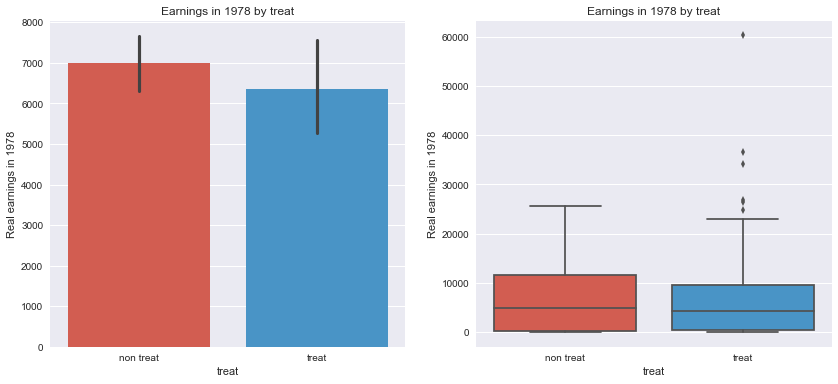

In [32]:
# plot the distribution for real earnings for 1978 for treated and control groups

plot_bar_box('treat', 're78', df, ['non treat', 'treat'],
             'Real earnings in 1978', 'Earnings in 1978 by treat')

### Observations

As we can see from the bar and the box plots, the population who are *treated* has a lower income (except for a few outliers). <br>
A naïve researcher may conclude that the treatment is inneficient, as it diminishes the income of the participant. 
<br><br>
The treatment seems to have no effect to the outcome. In the next task we will observe the data more carefully and try to make more detailed conclusions.
<br><br>




## 1.2  A closer look at the data

Now, we want to compare the two groups by each variable to see if there are some differences. First we plot pairwise relationships in the dataset. We use seaborn pairplot function for this.



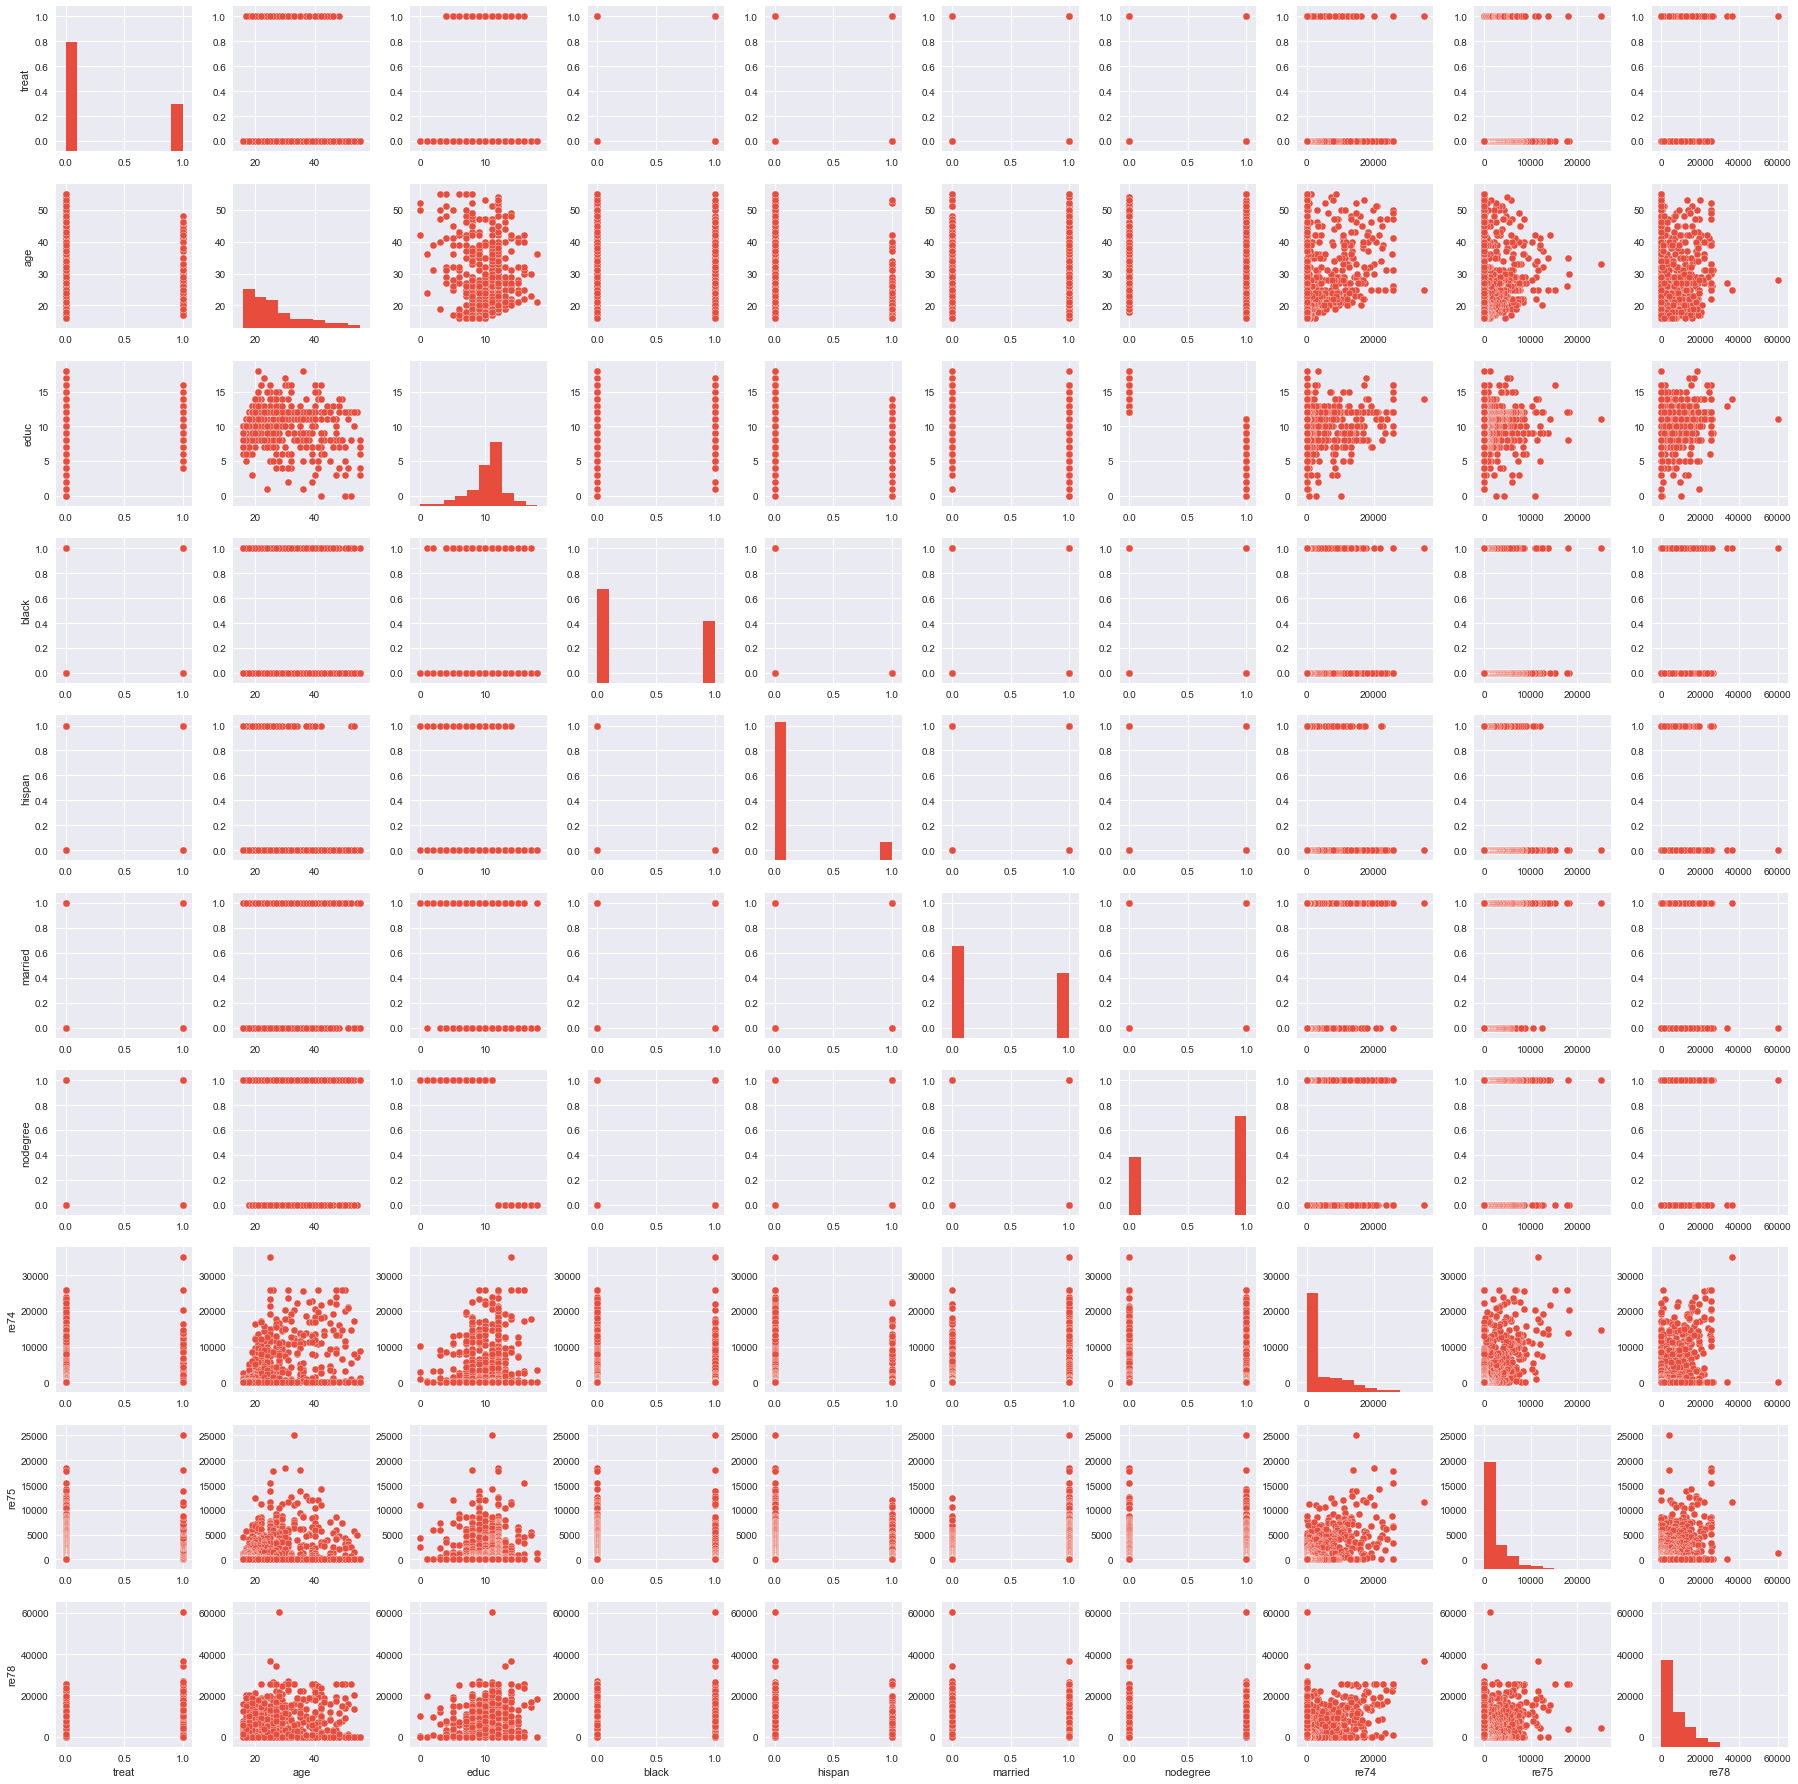

In [33]:
# plot pairwise relatioships in the dataset
pairplot(df)

### Observations

Observing the plots in this pairplot we make some conclusions about our dataset. There were more people that were not treated, more people that were not married, did not have a degree at the time of the training. We also notice that there are a lot of people during this period that did not have a job, so their salary was zero. 



### By age

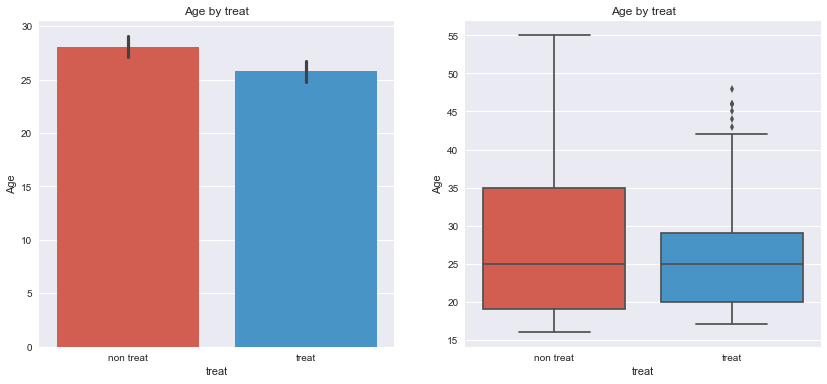

In [34]:
# box plot for age in treated and control group
plot_bar_box('treat', 'age', df, 
             ['non treat', 'treat'], 
             'Age', 'Age by treat')

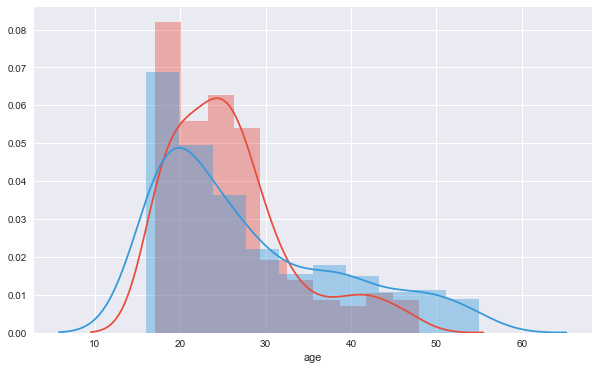

In [35]:
# plot the distributions for age for treated and control group

plot_distrib(df, 'age')

### Observations

We notice that the age distributions for treated and non-treated people are different.

### By years of education

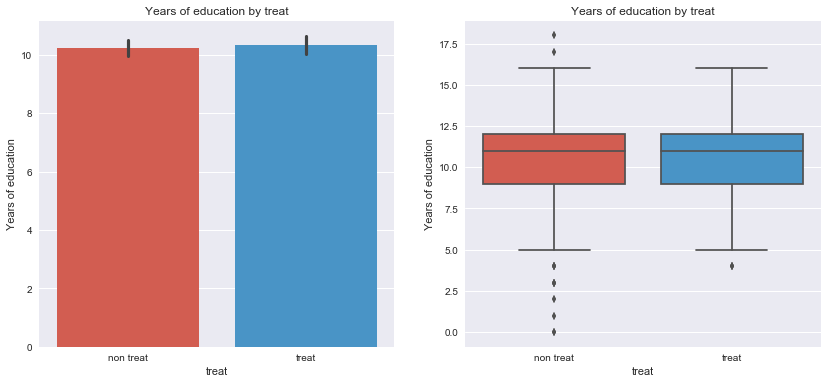

In [36]:
# plot years of education in box plot for treated and control group

plot_bar_box('treat', 'educ', df, ['non treat', 'treat'], 
             'Years of education', 'Years of education by treat')

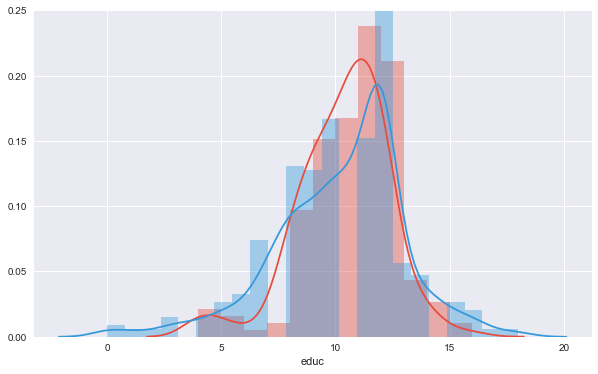

In [37]:
# plot the distributions for education for treated and control group

plot_distrib(df, 'educ')

### Observations

Here we observe that the distributions are also different. We notice that the control group has gaps in the education distibution. While in the treated group we have people with all education period durations. 

### By race

We will plot the distribution for different races for treated and non-treated groups.

In [38]:
# count the percentage of the participants by their race 
# we do this both for treated and control group

def get_ratio_feature(data, column):
    df_groups = data.groupby(['treat', column]).agg({'treat': 'count'})
    df_total = data.groupby(['treat']).agg({'treat': 'count'})
    df_ratio = df_groups.div(df_total) * 100
    df_ratio.columns = [column + ' %']
    df_ratio.reset_index(inplace=True)
    return df_ratio

In [39]:
df['race_str'] = 'white'
df.loc[df['black'] == 1, 'race_str'] = 'black'
df.loc[df['hispan'] == 1, 'race_str'] = 'hispan'

In [40]:
df_race_ratio = get_ratio_feature(df, 'race_str')

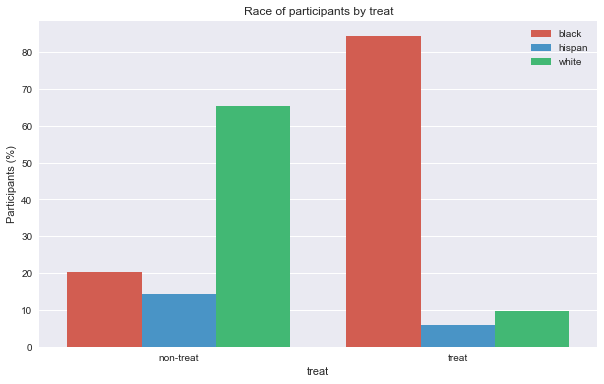

In [41]:
plot_histogram(df_race_ratio, 'treat', 'race_str %', 'race_str', 
               ['non-treat', 'treat'], 'Participants (%)', 
               'Race of participants by treat' )

### Observations

Here we observe that the distribution is not balanced. While in the control group we have the most white people, in the treated group the most of the people are black. 

### By marital status

In [42]:
df['married_str'] = 'not married'
df.loc[df['married'] == 1, 'married_str'] = 'married'
df_married_ratio = get_ratio_feature(df, 'married_str')

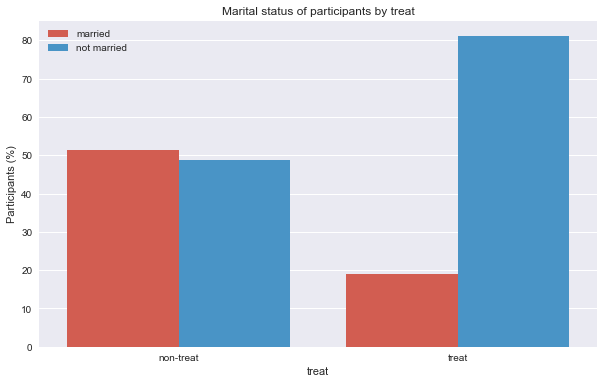

In [43]:
# plot the distributions for percentage of married people 
# this is done both for treated and control group

plot_histogram(df_married_ratio, 'treat', 'married_str %', 'married_str', 
               ['non-treat', 'treat'], 
               'Participants (%)', 'Marital status of participants by treat')

### Observations

We notice here that in the treated group the most of the people are not married, while in the control group the number of married and not married people is similar. 

### By degree status

In [44]:
# plot the distributions for percentage of people with and without degree
# this is done both for treated and control group

df['nodegree_str'] = 'have no degree'
df.loc[df['nodegree'] == 0, 'nodegree_str'] = 'have a degree'
df_degree_ratio = get_ratio_feature(df, 'nodegree_str')

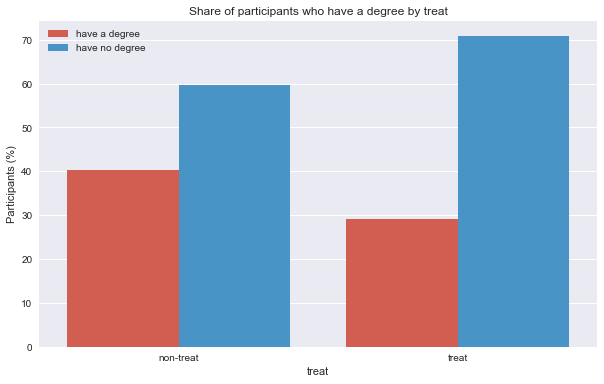

In [45]:
plot_histogram(df_degree_ratio, 'treat', 'nodegree_str %', 'nodegree_str', 
               ['non-treat', 'treat'], 
               'Participants (%)', 'Share of participants who have a degree by treat')

### Observations

In both of the groups people do not have a degree, which we find is an interesting observation. 

### Analysis by evolution

We will present the evolution of the earnings for people in different groups through these few years. 

In [46]:
df_evolution_nontreat = df.query('treat == 0')[['re74', 're75', 're78']]
df_evolution_treat = df.query('treat == 1')[['re74', 're75', 're78']]

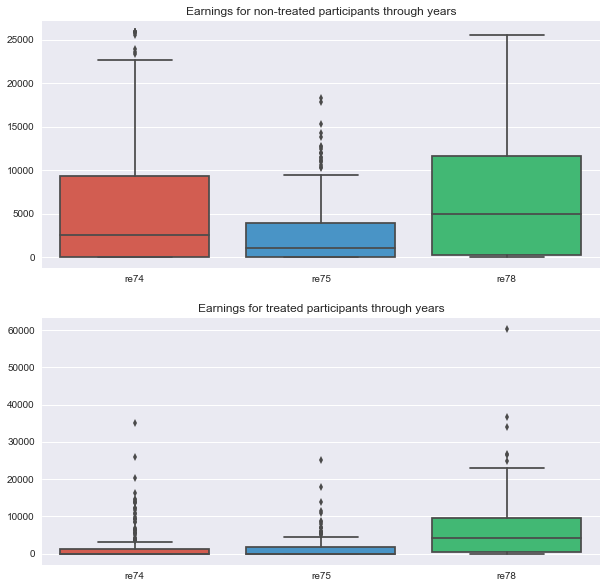

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax1 = sns.boxplot(data=df_evolution_nontreat, ax=ax[0])
ax1.set_title('Earnings for non-treated participants through years')
ax2 = sns.boxplot(data=df_evolution_treat, ax=ax[1])
ax2.set_title('Earnings for treated participants through years')
plt.show()

### Observations and conclusion
It seems that the two groups (treat and control) do not come from the same distribution, and this means that the naive interpretation is not acceptable.

### 3. A propensity score model

Here, we run a logistic model in order to get prospensity scores, as we have seen in lecture.


In [48]:
def run_logistic_regression_model(data, label_column, feature_cols):
    logistic = linear_model.LogisticRegression()
    X = pd.get_dummies(data[feature_cols])
    y = data[label_column]
    logistic.fit(X, y)
    pred = logistic.predict_proba(X)
    return pred

In [49]:
cols = ['age','educ','black','hispan','married','nodegree','re74','re75']
predictions = run_logistic_regression_model(df, 'treat', cols)
df_propensity = df.copy()
df_propensity['propensity_score'] = predictions[:,1]

In [50]:
df_propensity.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race_str,married_str,nodegree_str,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black,married,have no degree,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispan,not married,have no degree,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black,not married,have a degree,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black,not married,have no degree,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black,not married,have no degree,0.698286


### 4. Balancing the dataset via matching

Before running graph with the max_weight_matching algorithm, we compute each distance between treat datapoints and control datapoints. We want minimizing distance, but here we use an algorithm that matches with the maximum, so we have to compute 1 -distance.

In [51]:
def run_graph_matching(data):
    df_treat = data.query('treat == 1')
    df_control = data.query('treat == 0')
    
    graph = nx.Graph()
    edges = [(id_x, id_y, {'weight': 1 - np.abs(x['propensity_score'] - y['propensity_score'])}) \
         for (id_x, x) in df_treat.iterrows() for (id_y, y) in df_control.iterrows()]
    graph.add_edges_from(edges)
    matching = nx.max_weight_matching(graph, maxcardinality=True)
    return matching, graph

In [52]:
matching, graph = run_graph_matching(df_propensity)

In [55]:
##nx.draw(graph,pos=nx.spring_layout(graph)) 
df_matched = df[df.index.isin(list(matching))]

In [56]:
# Verify same number in each groups
df_matched.groupby('treat')['id'].count()

treat
0    185
1    185
Name: id, dtype: int64

The treat is efficient as we can see here:

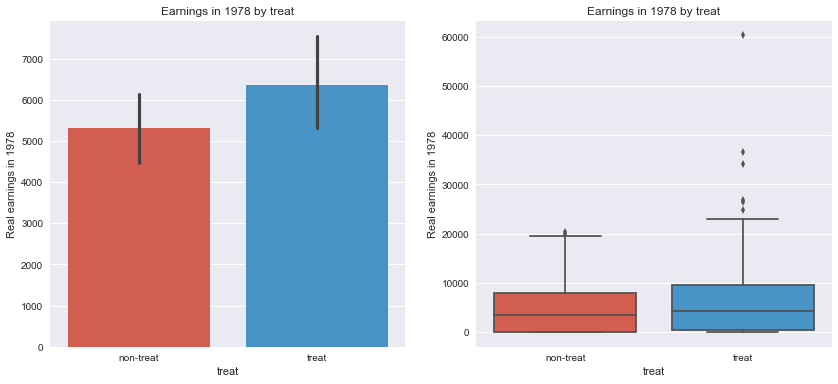

In [57]:
plot_bar_box('treat', 're78', df_matched, 
             ['non-treat', 'treat'], 
             'Real earnings in 1978', 'Earnings in 1978 by treat')

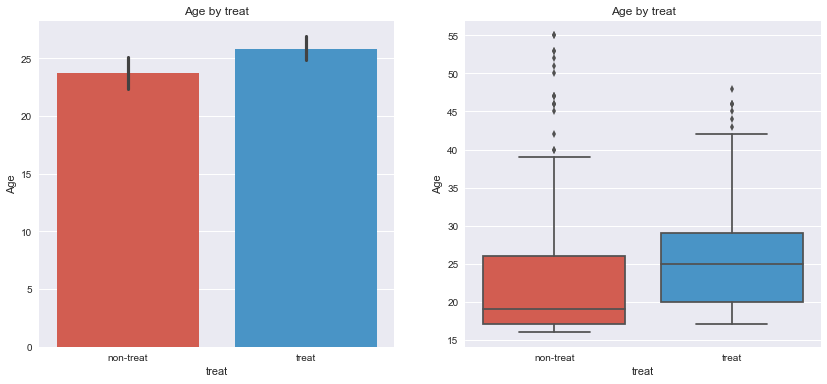

In [58]:
plot_bar_box('treat', 'age', df_matched, 
             ['non-treat', 'treat'], 
             'Age', 'Age by treat')

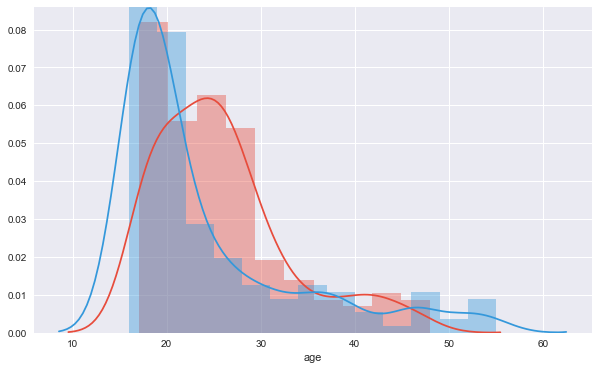

In [59]:
plot_distrib(df_matched, 'age')

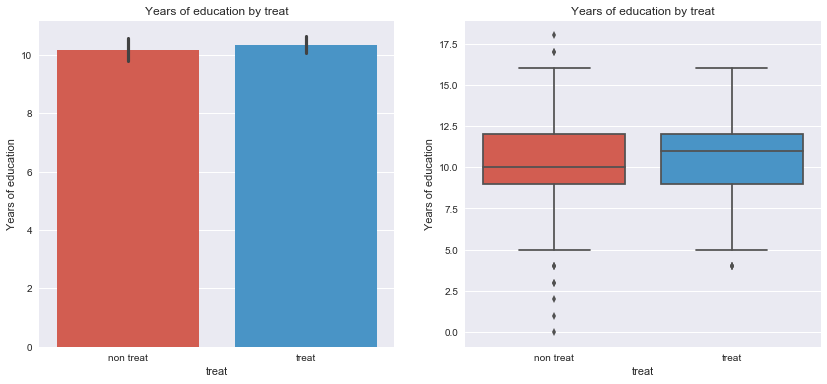

In [60]:
plot_bar_box('treat', 'educ', df_matched, 
             ['non treat', 'treat'], 
             'Years of education', 'Years of education by treat')

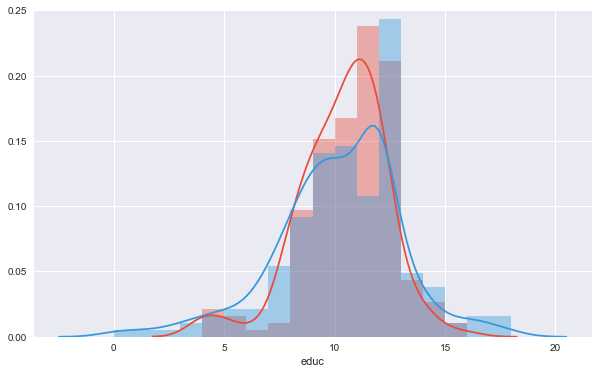

In [61]:
plot_distrib(df_matched, 'educ')

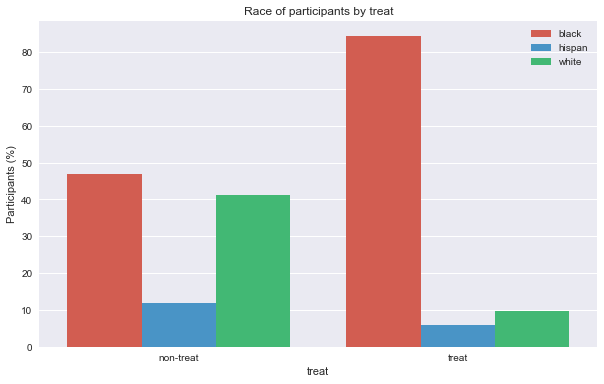

In [62]:
df_race_ratio = get_ratio_feature(df_matched, 'race_str')

plot_histogram(df_race_ratio, 'treat', 'race_str %', 'race_str', 
               ['non-treat', 'treat'], 
               'Participants (%)', 'Race of participants by treat')

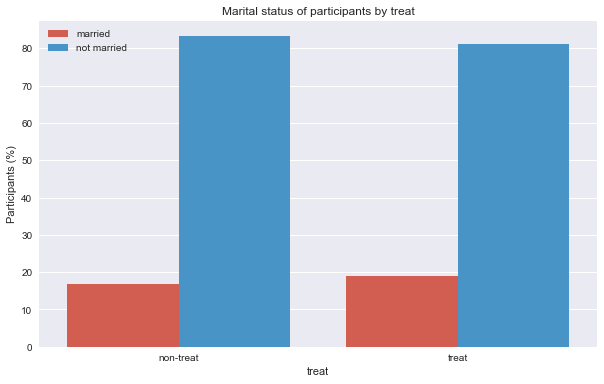

In [63]:
df_married_ratio = get_ratio_feature(df_matched, 'married_str')

plot_histogram(df_married_ratio, 'treat', 'married_str %', 'married_str', 
               ['non-treat', 'treat'], 
               'Participants (%)', 'Marital status of participants by treat')

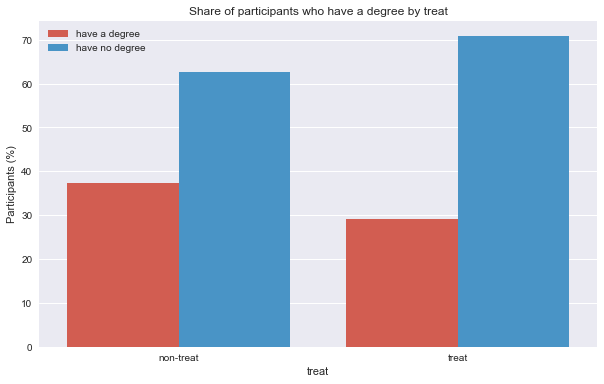

In [64]:
df_degree_ratio = get_ratio_feature(df_matched, 'nodegree_str')
plot_histogram(df_degree_ratio, 'treat', 'nodegree_str %', 'nodegree_str', 
               ['non-treat', 'treat'], 
               'Participants (%)', 'Share of participants who have a degree by treat')

### Observations

Here we notice that the distributions did not change significantly using previosly described propensity score matching. Because of this we need to balance the groups further. 

### 5. Balancing the groups further

We notice that there are still more black people in the control group than in the treated. Idea is to run three different models for each race and to see which result will this give us.




In [65]:
# WHITE
df_white = df.copy().query('race_str == "white"')
predictions = run_logistic_regression_model(df_white, 'treat', ['age','educ','married','nodegree','re74','re75'])
df_white['propensity_score'] = predictions[:,1]
matching_white = run_graph_matching(df_white)[0]
df_matched_white = df_white[df_white.index.isin(list(matching_white))]

# BLACK
df_black = df.copy().query('race_str == "black"')
predictions = run_logistic_regression_model(df_black, 'treat', ['age','educ','married','nodegree','re74','re75'])
df_black['propensity_score'] = predictions[:,1]
matching_black = run_graph_matching(df_black)[0]
df_matched_black = df_black[df_black.index.isin(list(matching_black))]

# HISPAN
df_hispan = df.copy().query('race_str == "hispan"')
predictions = run_logistic_regression_model(df_hispan, 'treat', ['age','educ','married','nodegree','re74','re75'])
df_hispan['propensity_score'] = predictions[:,1]
matching_hispan = run_graph_matching(df_hispan)[0]
df_matched_hispan = df_hispan[df_hispan.index.isin(list(matching_hispan))]

frames = [df_matched_white, df_matched_black, df_matched_hispan]

df_matched_new = pd.concat(frames)

### 6. A less naive analysis



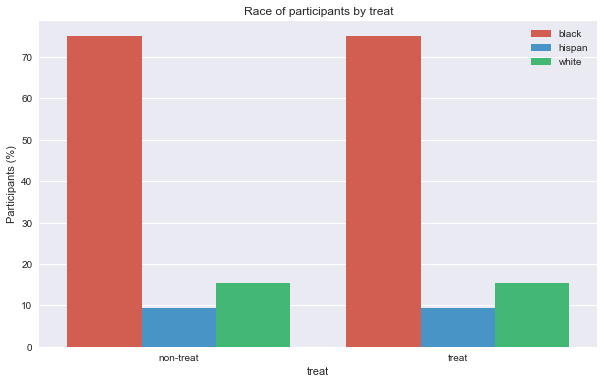

In [69]:
df_race_ratio = get_ratio_feature(df_matched_new, 'race_str')
plot_histogram(df_race_ratio, 'treat', 'race_str %', 'race_str', 
               ['non-treat', 'treat'], 
               'Participants (%)', 'Race of participants by treat')

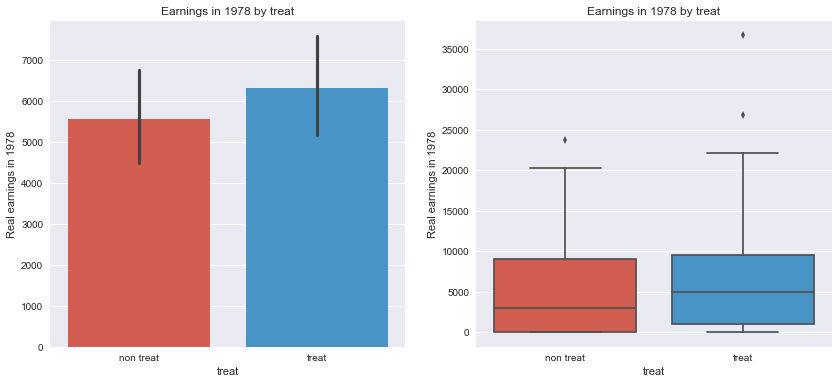

In [70]:
plot_bar_box('treat', 're78', df_matched_new, 
             ['non treat', 'treat'], 
             'Real earnings in 1978', 'Earnings in 1978 by treat')

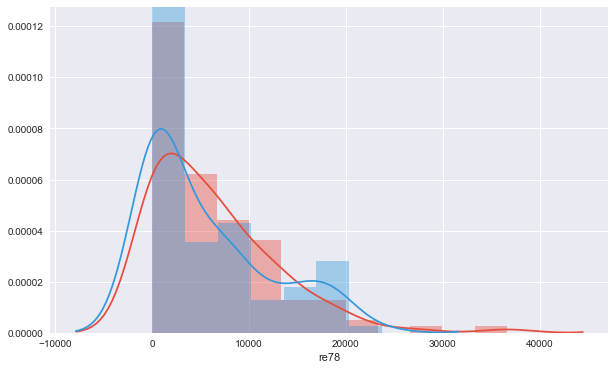

In [71]:
plot_distrib(df_matched_new, 're78')

### Observations

After more analysis, we can conclude that we now have similar distribution for the salary in 1978. for both treated and control groups. 

<br>

# Question 2 - Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


## Task 1.


Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).



## Solution


We will read the dataset and split it into training, testing and validation set first.


In [72]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [73]:
newsgroups = fetch_20newsgroups(data_home='20newsgroups', subset='all')

In [74]:
tfid = TfidfVectorizer()
vectors = tfid.fit_transform(newsgroups.data)

In [75]:
X = vectors
y = newsgroups.target

In [76]:
# 80% + 10% of training + validation together, then 10% of test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=1)

#ShuffleSplit will test 2 random splits with the validation set
s = ShuffleSplit(n_splits=2, test_size=0.1111, random_state=0)

In [81]:
param_grid = {
                 'n_estimators': np.arange(100, 1100, 100),
                 'max_depth': [None, 5, 10, 30]
             }

In [82]:
rfc = RandomForestClassifier()

In [83]:
rfc_gridsearch = GridSearchCV(rfc, param_grid=param_grid, verbose=2, cv=s)

<br>
We will use the best hyperparameters to train our random forest classifier.<br>
The following cell is used to save in a file all the results of our grid search in order to tune the hyperparameters.


In [ ]:
rfc_gridsearch.fit(X, y)
#print(rfc_gridsearch.best_params_)
results = pd.DataFrame(rfc_gridsearch.cv_results_)
results.to_csv(path_or_buf='data/results_gridsearch.csv', encoding='utf8')

Now, we fit the best model to the training data. <br>
Then, we can predict the testing set using our model

In [84]:
rfc.set_params(n_estimators=800, max_depth=None) # The best parameters we have found with grid search
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
y_pred = rfc.predict(X_test)
accuracy_score(y_pred, y_test)

0.86949602122015912

We got accuracy of **~87%**. Below we print the report for classification, with details for each group of the news. 

In [87]:
print(classification_report(y_test, y_pred, target_names=newsgroups.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.91      0.81      0.86        78
           comp.graphics       0.73      0.82      0.77       101
 comp.os.ms-windows.misc       0.79      0.92      0.85        96
comp.sys.ibm.pc.hardware       0.77      0.83      0.80       110
   comp.sys.mac.hardware       0.89      0.81      0.85       101
          comp.windows.x       0.88      0.85      0.86       101
            misc.forsale       0.74      0.88      0.80        93
               rec.autos       0.88      0.85      0.87       109
         rec.motorcycles       0.95      0.96      0.96       103
      rec.sport.baseball       0.93      0.87      0.90       101
        rec.sport.hockey       0.94      0.98      0.96       110
               sci.crypt       0.95      0.96      0.96       104
         sci.electronics       0.83      0.67      0.74        79
                 sci.med       0.87      0.90      0.89        90
         

### Confusion matrix 


Then, we can plot the confusion matrix to evaluate the accuracy on the test set. The confusion matrix show that the two terms that are mostly confused are talk.religion.misc and soc.religion.christian.

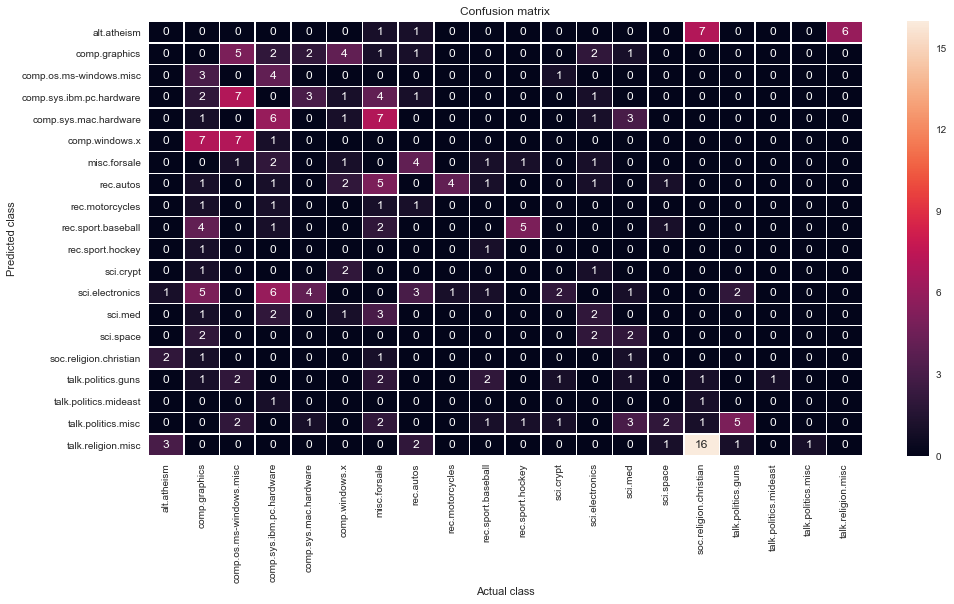

In [88]:
cm = confusion_matrix(y_test, y_pred)
np.fill_diagonal(cm, 0)

fig, ax = plt.subplots(1, figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=newsgroups.target_names, yticklabels=newsgroups.target_names)
ax.set_title('Confusion matrix')
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.show()

### Feature importance

Let us represent the 20 most important features for the classification of the articles. We observe that the words that are the most significant for the classification are dod, isreal, encryption, etc..

In [89]:
df_vocab = pd.DataFrame.from_dict(tfid.vocabulary_, orient='index')
df_vocab = df_vocab.reset_index().set_index(0, drop=True).sort_index()
df_vocab.columns = ['word']
df_vocab['importance'] = rfc.feature_importances_
df_vocab = df_vocab.sort_values('importance', ascending=False).head(20)

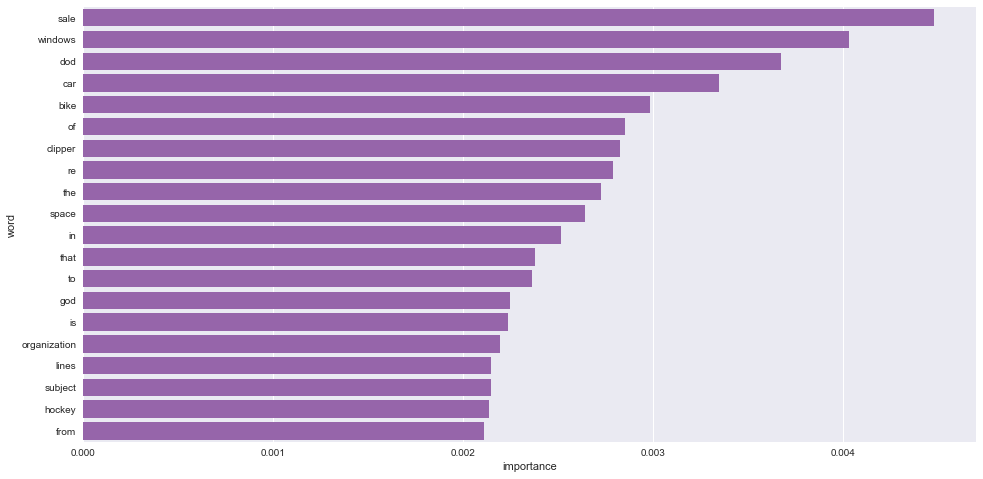

In [90]:
fig, ax = plt.subplots(1, figsize=(16, 8))
sns.barplot(x="importance", y="word", data=df_vocab, color='#9b59b6')

We can notice that we have a lot of randomness in the importance of words. It can be explained by the way the random forest trees were built, according the order of the articles were treated.